In [78]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# load data
train_data = unpickle('data/cifar-10-batches-py/data_batch_1')
test_data = unpickle('data/cifar-10-batches-py/test_batch')
val_data = unpickle('data/cifar-10-batches-py/data_batch_2')

train, train_labels = train_data[b'data'], train_data[b'labels']
test, test_labels = test_data[b'data'], test_data[b'labels']
val, val_labels = val_data[b'data'], val_data[b'labels']

data_meta = unpickle('data/cifar-10-batches-py/batches.meta')
label_name = {i: data_meta[b'label_names'][i] for i in range(10)}

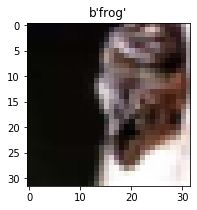

In [4]:
# visualize cifar-10 images
i = np.random.randint(len(train))
x = train[i].reshape(32, 32, 3, order='F')
fig = plt.figure(figsize=(3, 3))
plt.title(label_name[train_labels[i]])
plt.imshow(x)

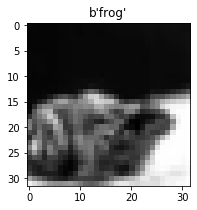

In [5]:
# turn into gray scale image using Luma coding
train_gray = 0.2989 * train[:, :1024] + 0.5870 * train[:, 1024:2048] + 0.1140 * train[:, -1024:]
test_gray = 0.2989 * test[:, :1024] + 0.5870 * test[:, 1024:2048] + 0.1140 * test[:, -1024:]

# visualize
x = train_gray[i].reshape(32, 32)
fig = plt.figure(figsize=(3, 3))
plt.title(label_name[train_labels[i]])
plt.imshow(x, cmap='gray')

### Classify

In [6]:
from estimator import gabor_random_features, relu, RFClassifier

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [7]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:35415 Dashboard: http://127.0.0.1:46117/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [62]:
X_train, y_train = train_gray.copy(), np.array(train_labels.copy())
X_test, y_test = test_gray.copy(), np.array(test_labels.copy())
N = X_train.shape[1]
n = int(np.sqrt(N))

idx = np.logical_or(y_train == 3, y_train == 5)
X_train, y_train = X_train[idx], y_train[idx]

idx = np.logical_or(y_test == 3, y_test == 5)
X_test, y_test = X_test[idx], y_test[idx]

In [54]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

t = 5 # scale of bump
l = 3 # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = relu

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 19, 22, 25, 29, 33, 39, 44, 51, 59, 68, 79, 91, 104, 120, 138, 159, 184, 212, 244, 281, 323, 372, 429, 494, 568, 655, 754, 868, 1000]


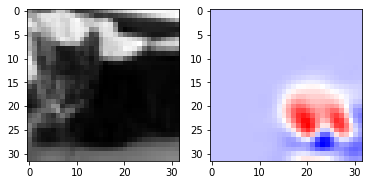

In [44]:
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(X_train[0].reshape(32, 32), cmap='gray')

ax = fig.add_subplot(122)
W = gabor_random_features(3, N, 5, 3)
plt.imshow(W[0].reshape(32, 32), cmap='bwr')

In [55]:
# %%time 
# results = {wt:[] for (wt, func) in weights}
# for (wt, func) in weights:
#     for n in n_features:
#         params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
#         lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
#                                             y_test) for _ in range(5)]
#         results[wt].append(np.real(dask.compute(*lazy_results)))
#         print(wt, n)
# import pickle
# with open('figures/cifar_10_clf/cifar_10_clf_t=%0.2f_l=%0.2f.pickle'% (t, l), 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
t = 5
l = 3
with open('figures/cifar_10_clf/cifar_10_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'rb') as handle:
    results = pickle.load(handle)

# compute mean
mean_err_gabor, std_err_gabor = np.mean(results['gabor'], 
                                                    axis=1), np.std(results['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], 
                                              axis=1), np.std(results['white noise'], axis=1)

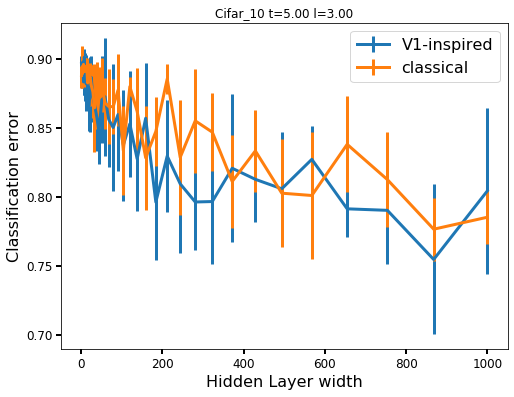

In [76]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='V1-inspired',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  
            markersize=4, lw=3)
# ax.set_yscale('log')
# plt.xlim([0, 200])
ax.set_title('Cifar_10 t=%0.2f l=%0.2f' % (t, l))
plt.xlabel('Hidden Layer width', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)
# plt.savefig('figures/cifar_10_clf/clf_t=%0.2f_l=%0.2f.png'% (t, l))

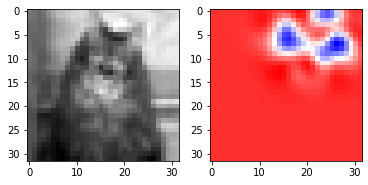

In [77]:
W = gabor_random_features(20, N, t, l)
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(X_train[3].reshape(n, n), cmap='gray')

ax = fig.add_subplot(122)
plt.imshow(W[0].reshape(n, n), cmap='bwr')

In [16]:
label_name

{0: b'airplane',
 1: b'automobile',
 2: b'bird',
 3: b'cat',
 4: b'deer',
 5: b'dog',
 6: b'frog',
 7: b'horse',
 8: b'ship',
 9: b'truck'}